In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input, Reshape, MaxPooling2D, Conv2D, Dense, Flatten
from tensorflow.python.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

base_path = "/Users/jamesgolding/git/python/Kaggle/Fruits";

WIDTH = 32
HEIGHT = 32
CHANNELS = 3

train_path = base_path + "/Training";
test_path = base_path + "/Test";

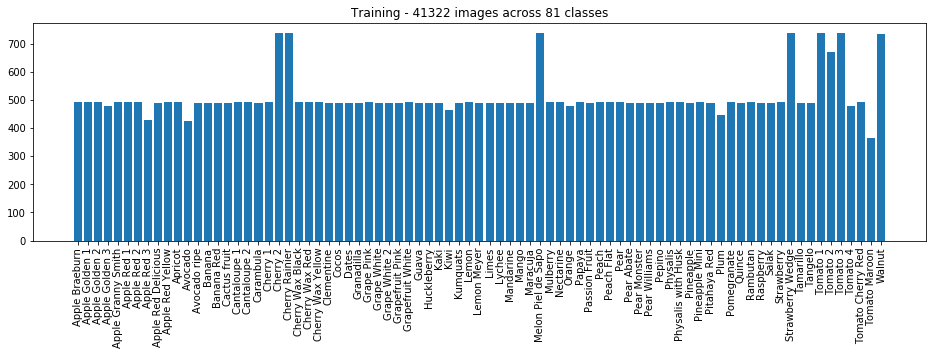

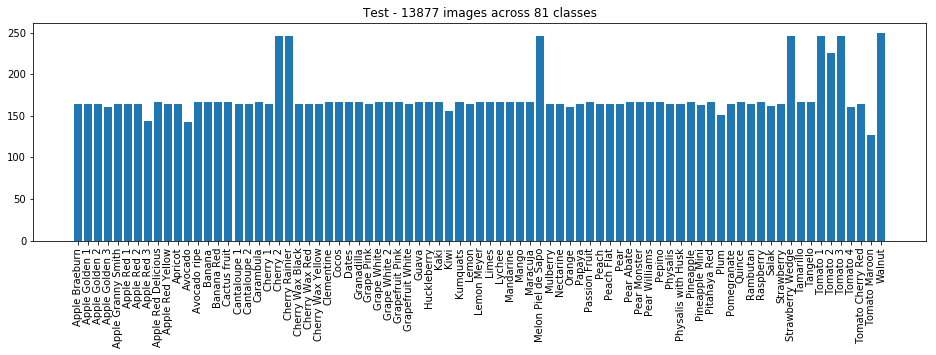

In [2]:
# create list of image paths and categories
def getfruits(path, fruit_names=None):
    i = -1;
    img_label = [];
    img_paths = [];
    fruit_dict = {};
    if fruit_names is None:
        fruit_names = os.listdir(path);
    for fruit_name in fruit_names:
        if os.path.isdir(path + "/" + fruit_name):
            i += 1;
            img_names = os.listdir(path + "/" + fruit_name);
            fruit_dict[fruit_name] = len(img_names);
            for img_name in img_names:
                if img_name.endswith(".jpg"):
                    img_label.append(i)
                    img_paths.append(path + "/" + fruit_name + "/" + img_name);
    return img_paths, img_label, fruit_dict;

def onehotconvert(ids, n_classes):
    onehot = np.zeros(shape=[len(ids), n_classes])
    onehot[np.arange(len(ids)), np.array(ids)] = 1
    return onehot;

# get training fruit paths and labels
train_paths, train_labelids, train_summary = getfruits(train_path);
fruit_names = train_summary.keys();
# get test fruit paths and put them into the same groups
test_paths, test_labelids, test_summary = getfruits(test_path, fruit_names);

num_train = len(train_paths)
num_test = len(test_paths)
num_classes = len(train_summary.keys())
sz_image = WIDTH * HEIGHT * CHANNELS
shape_image = (WIDTH, HEIGHT, CHANNELS)

# onehot convert the labels
train_labels = onehotconvert(train_labelids, num_classes)
test_labels = onehotconvert(test_labelids, num_classes)

plt.figure(figsize=(16,4));
plt.bar(train_summary.keys(), train_summary.values());
plt.xticks(rotation='vertical');
plt.title("Training" + " - " + str(num_train) + " images across " + str(num_classes) + " classes");
plt.figure(figsize=(16,4));
plt.bar(test_summary.keys(), test_summary.values());
plt.xticks(rotation='vertical');
plt.title("Test" + " - " + str(num_test) + " images across " + str(num_classes) + " classes");

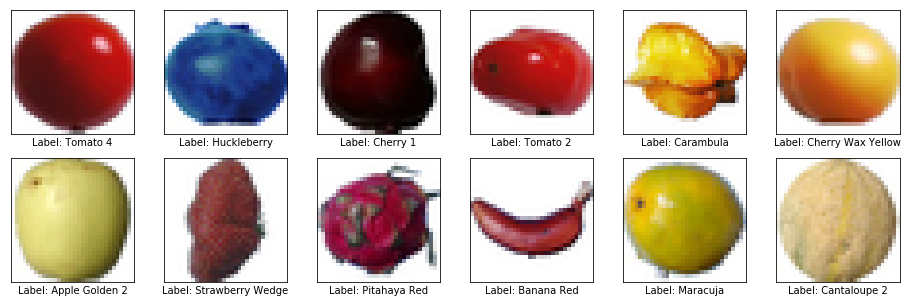

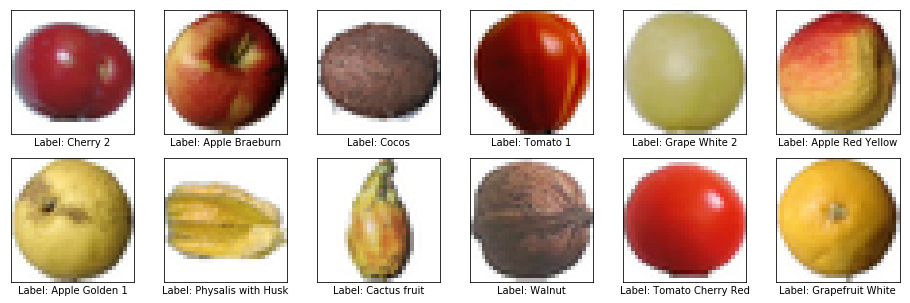

In [3]:
# helper to plot an array of images
def plotimages(images, label, label_pred=None):
    assert len(images) == len(label)
    label_names = list(fruit_names);
    for ifig in range(np.int(np.ceil(len(label) / 12))):
        fig, axes = plt.subplots(2, 6)
        fig.set_figheight(5)
        fig.set_figwidth(16)
        for i, ax in enumerate(axes.flat):
            i_data = ifig * 12 + i
            ax.set_xticks([])
            ax.set_yticks([])
            if i_data < len(images):
                ax.imshow(images[i_data].reshape(WIDTH, HEIGHT, CHANNELS))
                if label_pred is None:
                    ax.set_xlabel("Label: {0}".format(label_names[label[i_data]]))
                else:
                    ax.set_xlabel("Label: {0} \n Pred: {1}".format(label_names[label[i_data]], label_names[label_pred[i_data]]))

# load images and test
def readimages(filenames):
    x = np.zeros(shape=(len(filenames), sz_image))
    for i in range(len(filenames)):
        img = Image.open(filenames[i])
        img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
        img = np.asarray(img) / 255.0
        x[i,:] = img.flatten();
    return x;
num_step = np.int(np.ceil(len(train_paths) / 12 / 2))
train_images_test = readimages(train_paths[::num_step])
plotimages(train_images_test, train_labelids[::num_step])

In [4]:
# define model
model = Sequential()
model.add(InputLayer(input_shape=(sz_image,)))
model.add(Reshape(shape_image))

model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding="same", activation="relu", name="conv1"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding="same", activation="relu", name="conv2"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding="same", activation="relu", name="conv3"))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

optimizer = Adam(lr=1e-3)

num_batch = 100;
num_epochs = 2;

In [5]:
# load in all the images
train_images = readimages(train_paths)

In [6]:
# compile the model, define the loss function and metrics
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]);
# fit to the training data
model.fit(x=train_images, y=train_labels, epochs=num_epochs, batch_size=num_batch);

Epoch 1/2
41322/41322 [==============================] - 69s 2ms/step - loss: 0.9800 - acc: 0.7387
Epoch 2/2
41322/41322 [==============================] - 66s 2ms/step - loss: 0.0984 - acc: 0.9714


In [7]:
test_images = readimages(test_paths)
# evaluate the model for the test set
result = model.evaluate(x=test_images,
                        y=test_labels)
y_pred = model.predict(x=test_images)
# print the accuracy for every result
for name, value in zip(model.metrics_names, result):
    print(name, value)

13877/13877 [==============================] - 10s 710us/step
loss 0.3181046791198399
acc 0.9022843554082295


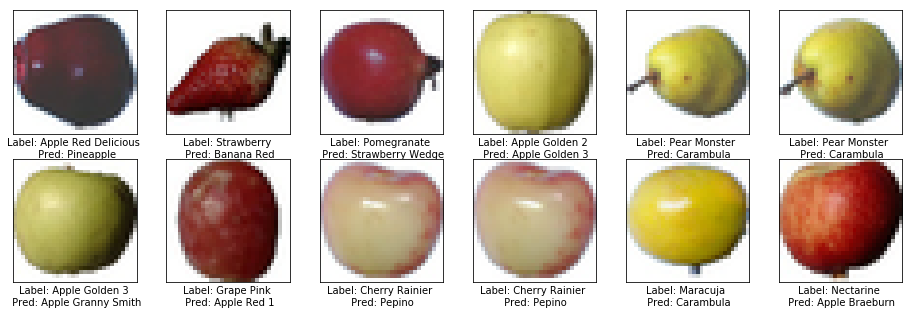

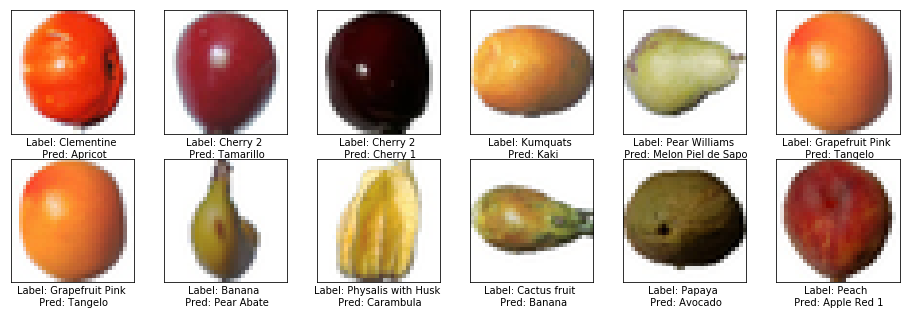

In [8]:
# convert output to index (which is the same as the digit anyway)
test_labelids = np.asarray(test_labelids)
test_labelids_pred = np.argmax(y_pred, axis=1)
correct = test_labelids_pred==test_labelids
# show some example images that are incorrect
images_incorrect = test_images[correct==False]
labelids_pred_incorrect = test_labelids_pred[correct==False]
labelids_incorrect = test_labelids[correct==False]
num_step = np.int(np.ceil(len(images_incorrect) / 12 / 2))
plotimages(images_incorrect[::num_step], labelids_incorrect[::num_step], labelids_pred_incorrect[::num_step])

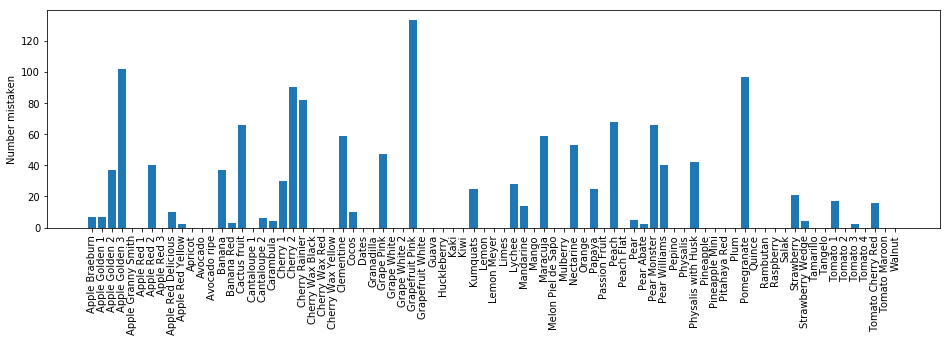

In [9]:
error_summary = {};
for i, name in zip(range(num_classes), fruit_names):
    error_summary[name] = len(labelids_incorrect[labelids_incorrect==i]);
plt.figure(figsize=(16, 4));
plt.bar(error_summary.keys(), error_summary.values());
plt.xticks(rotation='vertical');
plt.ylabel("Number mistaken");